In [1]:
# import packages
import time
from datetime import timedelta, datetime, date
import arrow 
import pdb
import glob 

from os.path import join
import os
from os import listdir
from os.path import isfile, join
import csv

import numpy as np
import numpy.matlib
import pandas as pd


import io
from runeq import Config, stream

import matplotlib.pyplot as plt
from matplotlib import figure
%matplotlib inline

'''
print('Download runeq, via Terminal: pip install runeq')
Rune instructions: https://github.com/rune-labs/opensource/blob/master/jupyter-notebook-templates/00_python_installation_instructions.md
documentation Rune functions: https://github.com/rune-labs/opensource/blob/master/jupyter-notebook-templates/02_download_watch_data.ipynb
Make sure that runeq is up-to-date before you run by running: 
pip install pipupgrade
pipupgrade --verbose --latest --yes

'''



"\nprint('Download runeq, via Terminal: pip install runeq')\nRune instructions: https://github.com/rune-labs/opensource/blob/master/jupyter-notebook-templates/00_python_installation_instructions.md\ndocumentation Rune functions: https://github.com/rune-labs/opensource/blob/master/jupyter-notebook-templates/02_download_watch_data.ipynb\nMake sure that runeq is up-to-date before you run by running: \npip install pipupgrade\npipupgrade --verbose --latest --yes\n\n"

# Downloading RCS-Accelerometry or -Neural data via Rune platform

Code requires one folder with a patient-specific folder per patient.

Code requires on folder 'config files' in main path, containing the configuration files for each specific patient. Documentation about how to create these files is given on the Rune-Github: https://github.com/rune-labs/opensource/blob/master/jupyter-notebook-templates/02_download_watch_data.ipynb.

In [2]:
# set the path to the directory in which the repo exists 
path = os.path.dirname(os.getcwd())
print(path)

/Users/jeroenhabets/Desktop/UCSF_Bradykinesia_Detection/medStateDetection


In [3]:
# set up config for Rune RCS data extraction
# The Device-ID's differ from the Apple-watch device IDs!! 

# (https://github.com/rune-labs/opensource/blob/master/jupyter-notebook-templates/02_download_watch_data.ipynb)


'''
Config files are patient and user specific. Open yaml-files to enter personal client key and access key.
To get keys: log in in Rune-labs as admin; click edit-pencil next to patients name;
go to Clients; make new Client; copy keys to yaml-file
'''

cfg_RCS02 = Config(os.path.join(path,'config_files','rune_Jeroen_watch_config_RCS02.yaml'))
cfg_RCS05 = Config(os.path.join(path,'config_files','rune_Jeroen_watch_config_RCS05.yaml'))
cfg_RCS06 = Config(os.path.join(path,'config_files','rune_Jeroen_watch_config_RCS06.yaml'))
cfg_RCS07 = Config(os.path.join(path,'config_files','rune_Jeroen_watch_config_RCS07.yaml'))

clients = {'RCS02_left' : stream.V1Client(cfg_RCS02),'RCS02_right' : stream.V1Client(cfg_RCS02),
           'RCS05_left' : stream.V1Client(cfg_RCS05),'RCS05_right' : stream.V1Client(cfg_RCS05),
          'RCS06_left': stream.V1Client(cfg_RCS06), 'RCS06_right': stream.V1Client(cfg_RCS06),
           'RCS07_left': stream.V1Client(cfg_RCS07),'RCS07_right': stream.V1Client(cfg_RCS07)}

# device_ids are ID's for patient's RCS's, for all patient right-sided RCS
deviceIDS = {'RCS02_right': 'DeviceNPC700404H', 'RCS02_left': 'DeviceNPC700398H',
             'RCS05_right': 'DeviceNPC700415H', 'RCS05_left': 'DeviceNPC700414H',
             'RCS06_right': 'NPC700425H', 'RCS06_left': 'NPC700424H', 
             'RCS07_right': 'NPC700403H', 'RCS07_left': 'NPC700419H'}







In [73]:
def downloadRCSData(pt_side,data_type,y0,m0,d0,y1,m1,d1):
    '''
    Function downloads csv files with RCS accelerometry (always with gravity, no internal
    filtering), or neural data for seperate days, within a given time period.
    Input:
    - pt_side = patient and side as string (e.g. 'RCS02_right' or 'RCS05_left')
    - data_type = 'accel', or 'neuralStates'
    - y0,m0,d0 : start date of desired timeperiod (year, month, date, e.g. 2020, 5, 1)
    - y1,m1,d1 : end date of desired timeperiod (year, month, date, e.g. 2020, 6, 1)
    
    Saves csv files in patient folder within given path-folder.
    '''
    
    '''
    Configurations for extraction via Rune platform
    Source: https://github.com/rune-labs/opensource/blob/master/jupyter-notebook-templates/02_download_watch_data.ipynb
    
    Config files are patient and user specific. Open yaml-files to enter personal client key and access key.
    To get keys: log in in Rune-labs as admin; click edit-pencil next to patients name;
    go to Clients; make new Client; copy keys to yaml-file
    '''
    
    # define timespan
    def datetime_range(start=None, end=None):
        span = end - start
        for i in range(span.days + 1):
            yield start + timedelta(days=i)
    # create list with timestamps of beginning of all days in given time period
    datetimeDays = list(datetime_range(start=datetime(y0, m0, d0), end=datetime(y1, m1, d1)))
    for timeStart in datetimeDays: # loop over all days in requested timespan
        # define start time of download, as required tuple
        start = timeStart.timestamp()
#         start = time.mktime(timeStart.timetuple()) 
        print(pd.to_datetime(start, unit='s'))
        # download per day, so end of download is end of day
        timeEnd = timeStart + timedelta(days=1)
        # convert end-time in required time tuple        
        end = timeEnd.timestamp()
#         end = time.mktime(timeEnd.timetuple()) # convert to unix time

        # set download parameters with set start and endtimes
        downloadParameters = {'device_id': deviceIDS[pt_side], 
                              'start_time': start,
                              'end_time': end, 
                              'timestamp': 'unix'}

        '''
        Rune-function which makes API call for data, saves to CSV and outputs dataframe.
        PM: RCS only generates acc-data with gravity. So, expression=accel is used.
        '''
        
        # set download parameters with specific device, start and end date
        if data_type == 'accel':
            accessor = clients[pt_side].Accel(**downloadParameters, expression= "accel" )
        elif data_type == 'neuralStates':
            adaptive_fields = {
        'event': 'stimulation_state.adaptive',
        'fields': 'adaptive_state,'
                'ld0.threshold.high,'
                  'ld0.threshold.low,'
                  'ld0.output,'
                'ld1.threshold.high,'
                  'ld1.threshold.low,'
                  'ld1.output,'
                  }
            accessor = clients[pt_side].State( **downloadParameters, **adaptive_fields  )
        else:
            print('Check data_type entry')
            break
        # Extraction of Rune function
        df = pd.DataFrame()
        for page in accessor.iter_csv_text():
            page_df = pd.read_csv(io.StringIO(page))
            df = df.append(page_df, ignore_index=True)
        
        df.insert(loc=0, value=pd.to_datetime(df['time'], unit='s'), column='timeStamp')
        
        # define name of day-file
        day = timeStart.strftime("%d") # generate 2-digit day code
        month = timeStart.strftime("%m") # generate 2-digit month code
        year = timeStart.strftime("%Y") # generate 4-digit year code

        if df.shape[0] < 5: # selects days without available acc data
            print('%s %s %s had no recording.'% ( year, month, day)) # informing about days without recording
            continue # goes further to next day without writing file
        
        fileName = '%s_%s%s%s_RCS_%s.csv' % (pt_side, year, month, day, data_type)
        # save dataframe to a csv
        patient_dir_name = os.path.join(path,'data','%s' % pt_side[:5])
        try: 
            os.makedirs(patient_dir_name)
        except OSError as error: 
            print(error)
        df.to_csv(os.path.join(patient_dir_name,fileName), index=False)
        print('%s %s %s is written!'% ( year, month, day))
    
    return df



In [74]:
test = downloadRCSData(pt_side='RCS02_right', data_type='neuralStates', y0=2020, m0=6, d0=10, y1=2020, m1=6, d1=12)



2020-06-10 07:00:00
[Errno 17] File exists: '/Users/jeroenhabets/Desktop/UCSF_Bradykinesia_Detection/medStateDetection/data/RCS02'
2020 06 10 is written!
2020-06-11 07:00:00
2020 06 11 had no recording.
2020-06-12 07:00:00
[Errno 17] File exists: '/Users/jeroenhabets/Desktop/UCSF_Bradykinesia_Detection/medStateDetection/data/RCS02'
2020 06 12 is written!


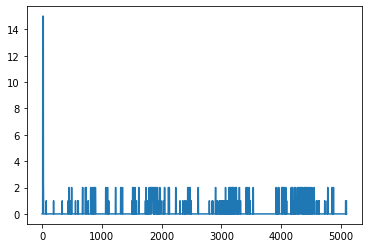

In [78]:
plt.plot(test['adaptive_state'])